# Chat Intents

## chatintents Tutorial

In [31]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

from hyperopt import hp

In [63]:
import chatintents
from chatintents import ChatIntents

In [119]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
from sentence_transformers import SentenceTransformer

## Load data and pre-trained models

In [6]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [7]:
all_intents = list(data_sample['text'])
len(all_intents)

1000

In [9]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 220.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 450.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 680.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 910.00MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [10]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')
model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
model_st3 = SentenceTransformer('paraphrase-mpnet-base-v2')
#model_st1 = SentenceTransformer('paraphrase-mpnet-base-v2')
#model_st2 = SentenceTransformer('paraphrase-distilroberta-base-v2')
#model_st3 = SentenceTransformer('stsb-mpnet-base-v2')

In [11]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences)
    
    return embeddings

In [12]:
embeddings_use = embed(model_use, 'use', all_intents)
embeddings_use.shape

TensorShape([1000, 512])

In [13]:
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)
embeddings_st1.shape

(1000, 768)

In [14]:
embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents)
embeddings_st2.shape

(1000, 384)

In [15]:
embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents)
embeddings_st3.shape

(1000, 768)

In [131]:
model_use = ChatIntents.ChatIntents(embeddings_use, 'use')
model_st1 = ChatIntents.ChatIntents(embeddings_st1, 'st1')
model_st2 = ChatIntents.ChatIntents(embeddings_st2, 'st2')
model_st3 = ChatIntents.ChatIntents(embeddings_st3, 'st3')

## Results with default hyperparameters

In [140]:
clusters_default = model_st1.generate_clusters(n_neighbors = 15, 
                                 n_components = 5, 
                                 min_cluster_size = 5, 
                                 min_samples = None,
                                 random_state=42)

In [141]:
labels_def, cost_def = model_st1.score_clusters(clusters_default)
print(labels_def)
print(cost_def)

56
0.146


## Tuning hyperparameters

### Random hyperparameter search

In [143]:
space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,15),
        "min_samples": range(2,15)
    }

random_st1 = model_st1.random_search(space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [144]:
random_st1.head(20)

,run_id,n_neighbors,n_components,min_cluster_size,min_samples,label_count,cost
41,41,14,4,12,14,11,0.032
43,43,12,3,12,2,37,0.040
32,32,12,6,9,2,46,0.059
85,85,12,5,10,5,38,0.081
46,46,13,5,8,3,48,0.084
52,52,12,3,9,2,49,0.087
19,19,14,3,10,4,42,0.095
54,54,15,3,6,3,61,0.096
75,75,14,5,12,5,35,0.096
56,56,13,3,13,5,31,0.097


### Bayesian optimization with Hyperopt

In [146]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,16)),
    "min_samples": None,
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals = 100

In [147]:
model_use.bayesian_search(space=hspace,
                          label_lower=label_lower, 
                          label_upper=label_upper, 
                          max_evals=max_evals)

100%|██████████| 100/100 [05:41<00:00,  3.42s/trial, best loss: 0.087]
best:
{'min_cluster_size': 5, 'min_samples': None, 'n_components': 10, 'n_neighbors': 3, 'random_state': 42}
label count: 55


In [148]:
model_use.best_params

{'min_cluster_size': 5,
 'min_samples': None,
 'n_components': 10,
 'n_neighbors': 3,
 'random_state': 42}

In [150]:
model_use.trials.best_trial

{'state': 2,
 'tid': 84,
 'spec': None,
 'result': {'loss': 0.087, 'label_count': 55, 'status': 'ok'},
 'misc': {'tid': 84,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [84],
   'n_components': [84],
   'n_neighbors': [84]},
  'vals': {'min_cluster_size': [3], 'n_components': [7], 'n_neighbors': [0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 9, 24, 0, 25, 49, 832000),
 'refresh_time': datetime.datetime(2021, 9, 24, 0, 25, 52, 368000)}

In [149]:
model_st1.bayesian_search(space=hspace,
                          label_lower=label_lower, 
                          label_upper=label_upper, 
                          max_evals=max_evals)                                                             

100%|██████████| 100/100 [06:09<00:00,  3.70s/trial, best loss: 0.038]
best:
{'min_cluster_size': 5, 'min_samples': None, 'n_components': 11, 'n_neighbors': 5, 'random_state': 42}
label count: 67


In [151]:
model_st2.bayesian_search(space=hspace,
                          label_lower=label_lower, 
                          label_upper=label_upper, 
                          max_evals=max_evals)

100%|██████████| 100/100 [04:59<00:00,  3.00s/trial, best loss: 0.076]
best:
{'min_cluster_size': 7, 'min_samples': None, 'n_components': 5, 'n_neighbors': 5, 'random_state': 42}
label count: 44


In [152]:
model_st3.bayesian_search(space=hspace,
                          label_lower=label_lower, 
                          label_upper=label_upper, 
                          max_evals=max_evals)

100%|██████████| 100/100 [05:30<00:00,  3.31s/trial, best loss: 0.062]
best:
{'min_cluster_size': 8, 'min_samples': None, 'n_components': 5, 'n_neighbors': 3, 'random_state': 42}
label count: 37


## Evaluate clusters

### Visually inspect clusters

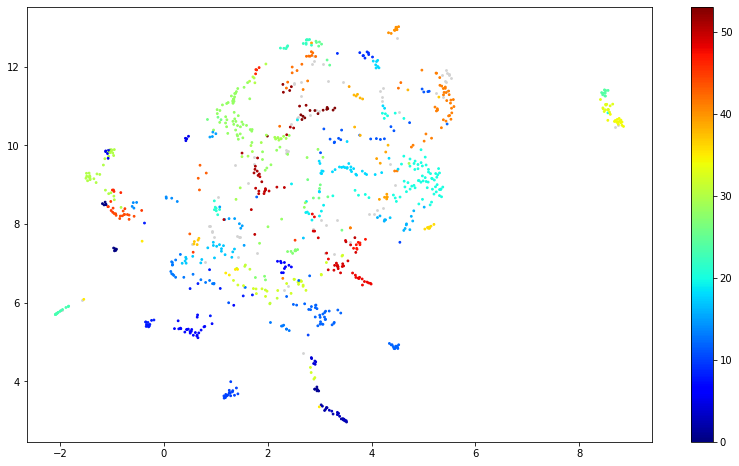

In [161]:
model_use.plot_best_clusters()

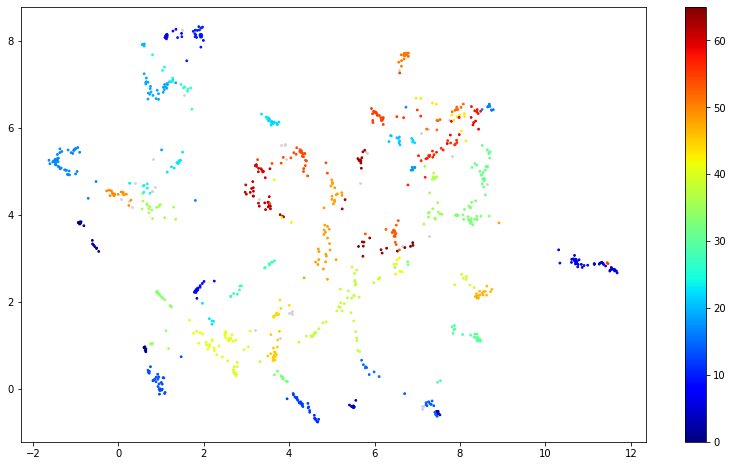

In [162]:
model_st1.plot_best_clusters()

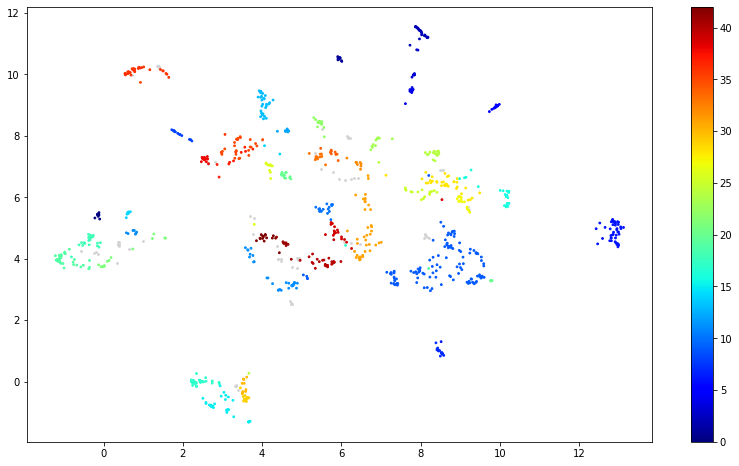

In [163]:
model_st2.plot_best_clusters()

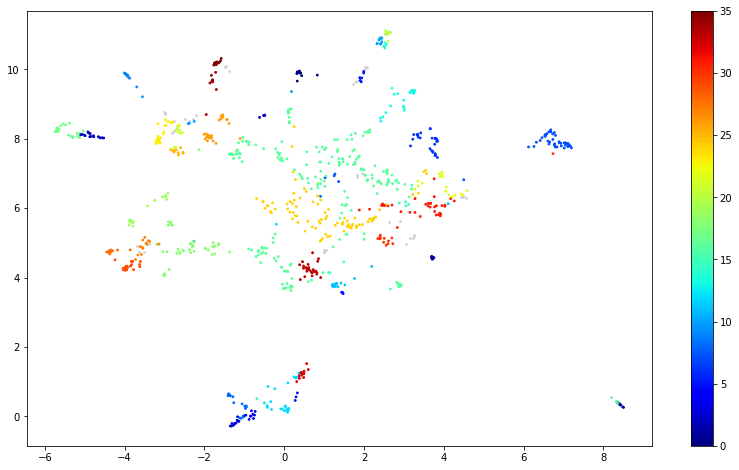

In [164]:
model_st3.plot_best_clusters()

### Apply labels

In [157]:
%%time

df_summary, labeled_docs = model_st1.apply_and_summarize_labels(data_sample[['text','c]])

CPU times: user 30.8 s, sys: 2.65 s, total: 33.5 s
Wall time: 36.5 s


In [158]:
df_summary.head()

,label_st1,count,label
18,17,45,pending_money_account
39,38,43,help_card_app
0,-1,38,use_money_account_identity
49,48,37,tried_cash_card
42,41,34,like_card_cost


In [159]:
labeled_docs.head()

,Unnamed: 0,text,category,cleaned_text,label_st1,label
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive,40,expect_card_week
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash,54,charged_fee_withdrawal_cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged,54,charged_fee_withdrawal_cash
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist,55,deposited_money_account_cash
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money,43,sent_money_friend_hour


### Compare clustering performance using ground truth labels

In [47]:
cluster_dict = {'label_use': best_clusters_use,
                'label_st1': best_clusters_st1} 
                #'label_st2': best_clusters_st2,
                #'label_st3': best_clusters_st3}

results_df = ChatIntents.combine_results(data_sample[['text', 'category']], cluster_dict)
    
results_df.head()

,text,category,label_use,label_st1
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,69,42
1,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,37,47
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,37,47
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,71,65
4,Are there ways for other people to send me money?,receiving_money,45,49


In [48]:
model_dict = {'USE': 'label_use',
              'Sent-Transformer_1': 'label_st1'} 
              #'Sent-Transformer_2': 'label_st2', 
              #'Sent-Transformer_3': 'label_st3'}

ChatIntents.comparison_table(model_dict, results_df)

,Model,ARI,NMI
1,Sent-Transformer_1,0.475,0.818
0,USE,0.280,0.722


In [130]:
df_summary.head()

,label_st1,count,label
0,-1,51,declined_money_transfer_beneficiary
22,21,49,use_account_card_auto
12,11,45,pending_money_account
3,2,44,help_refund_statement
13,12,38,help_card_app


In [49]:
data_clustered = results_df[['text', 'label_st1']].copy()
cluster_summary = ChatIntents.apply_and_summarize_labels(data_clustered, 'label_st1')

In [51]:
cluster_summary.head(20)

,label_st1,count,label
0,-1,61,tried_money_account_payment
6,5,45,help_refund_statement
20,19,42,help_card_app
45,44,35,pending_money_hour
42,41,35,like_card_cost
33,32,31,tell_payment_card
31,30,29,use_currency_app
40,39,29,explain_card_limit
48,47,28,charged_fee_withdrawal_cash
17,16,28,waiting_payment_card


In [52]:
labeled_clusters = pd.merge(data_clustered, cluster_summary[['label_st1', 'label']], on='label_st1', how = 'left')
labeled_clusters.head()

,text,label_st1,label
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,42,expect_card_week
1,I got charged a fee that shouldn't be there from my cash,47,charged_fee_withdrawal_cash
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,47,charged_fee_withdrawal_cash
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,65,deposited_cheque_balance_yesterday
4,Are there ways for other people to send me money?,49,sent_money_friend_hour


### With ground truth labels

In [53]:
data_ground = pd.read_csv('../data/processed/data_sample.csv')[['text', 'category']]
data_ground.head()

,text,category
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate
1,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit
4,Are there ways for other people to send me money?,receiving_money


In [54]:
labeled_clusters = ChatIntents.combine_ground_truth(labeled_clusters, data_ground, 'text')
labeled_clusters.head()

,text,label_st1,label,category
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,42,expect_card_week,card_delivery_estimate
1,I got charged a fee that shouldn't be there from my cash,47,charged_fee_withdrawal_cash,cash_withdrawal_charge
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,47,charged_fee_withdrawal_cash,cash_withdrawal_charge
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,65,deposited_cheque_balance_yesterday,balance_not_updated_after_cheque_or_cash_deposit
4,Are there ways for other people to send me money?,49,sent_money_friend_hour,receiving_money


#### Count and name of most common category of generated labels and clusters

In [56]:
ChatIntents.get_top_category(labeled_clusters, cluster_summary)

,label_st1,count,label,top_ground_category,top_cat_count,perc_top_cat
0,-1,61,tried_money_account_payment,cancel_transfer,7,11
1,5,45,help_refund_statement,Refund_not_showing_up,26,58
2,19,42,help_card_app,lost_or_stolen_card,10,24
3,44,35,pending_money_hour,pending_top_up,14,40
4,41,35,like_card_cost,order_physical_card,15,43
5,32,31,tell_payment_card,reverted_card_payment?,14,45
6,30,29,use_currency_app,fiat_currency_support,10,34
7,39,29,explain_card_limit,getting_virtual_card,9,31
8,47,28,charged_fee_withdrawal_cash,cash_withdrawal_charge,23,82
9,16,28,waiting_payment_card,pending_card_payment,21,75


### Manually inspect category consistency

In [60]:
labeled_clusters[labeled_clusters['label_st1']==2]

,text,label_st1,label,category
30,Where do I find my code to verify my top-up card?,2,find_card_verification_code,verify_top_up
209,Where do I find the verification code for the card I'm topping up?,2,find_card_verification_code,verify_top_up
317,How can I verify the top-up card?,2,find_card_verification_code,verify_top_up
509,I am having trouble finding the top-up card verification code.,2,find_card_verification_code,verify_top_up
774,I have a top up card. Where is the verification code?,2,find_card_verification_code,verify_top_up
828,Where can I find the top up verification code?,2,find_card_verification_code,verify_top_up
948,What's a verification code?,2,find_card_verification_code,verify_top_up


In [57]:
results_df[results_df['label_use']==2]

,text,category,label_use,label_st1
132,"I seem to have been charged to much for my holiday purchases, the exchange rate is wrong.",card_payment_wrong_exchange_rate,2,14
182,The correct exchange rate wasn't given to me for an item I purchased.,card_payment_wrong_exchange_rate,2,14
321,The exchange rate looks wrong on a holiday purchase,card_payment_wrong_exchange_rate,2,14
389,The exchange rate is incorrect on an item I recently purchased in a foreign country.,card_payment_wrong_exchange_rate,2,14
392,You did not give me the correct exchange rate for an item that I bought.,card_payment_wrong_exchange_rate,2,14
664,Can you change the rate for the item I bought in a different currency as it is wrong?,card_payment_wrong_exchange_rate,2,14


In [35]:
results_df[results_df['category']=='country_support']

,text,category,label_use,label_st1,label_st2,label_st3
11,Do you do business in the EU?,country_support,35,26,5,12
44,What are the countries you have offices in?,country_support,0,29,5,-1
122,Can I use this all over the world?,country_support,45,28,21,-1
279,What countries are you available in?,country_support,0,29,5,-1
295,What are the countries that you operate in?,country_support,0,29,5,-1
311,Can I get a card in the EU?,country_support,35,-1,5,12
503,Which countries do you operate in,country_support,0,29,5,-1
600,How do I know which countries you provide service in?,country_support,0,29,5,-1
724,"I'm not in the UK, but can I still get a card?",country_support,35,-1,5,-1
732,Can I get support?,country_support,-1,30,25,-1


Both USE and ST1 models have high precision for `country_support` category but also both miss many instances in that group.

In [36]:
results_df[results_df['category']=='card_about_to_expire']

,text,category,label_use,label_st1,label_st2,label_st3
27,"I am overseas in China, can I get a replacement card?",card_about_to_expire,12,-1,-1,25
370,"If I am in China, can I still order a new card and if so, how?",card_about_to_expire,12,-1,-1,25
441,My card is almost expired. How fast will I get a new one and what is the cost?,card_about_to_expire,6,49,27,16
477,My card is about to expire. Do I have to go to a branch to order a new card?,card_about_to_expire,6,49,27,16
521,"My card expires soon, will you send me one automatically?",card_about_to_expire,6,49,27,16
524,My card expires very soon. What is the cost and delivery time to get a new one?,card_about_to_expire,6,49,27,16
551,Where can I have a new bank card sent to China?,card_about_to_expire,12,-1,-1,25
584,How do I get a new expiration date?,card_about_to_expire,6,49,27,16
605,Are there any express fees if i want my new card faster?,card_about_to_expire,-1,49,17,16
646,My card is almost going to expire.,card_about_to_expire,6,49,-1,16


In [121]:
results_df[results_df['label_st1']==25]

,text,category,label_use,label_st1,label_st2,label_st3
12,"Can I add other people to my account, so they can top up?",topping_up_by_card,45,25,21,30
208,How can my friends top up my account?,topping_up_by_card,-1,25,21,30
549,Show me how can my friends top up my account.,topping_up_by_card,64,25,21,30
673,I want to top up my account. What payment methods are supported?,supported_cards_and_currencies,64,25,21,30
749,Help me to set up contactless payments.,contactless_not_working,68,25,-1,41
909,I want to use a payment card to top up my account. How can I do this?,supported_cards_and_currencies,64,25,21,30
